In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpmath import *
from scipy.stats import gamma
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull
from matplotlib.cm import ScalarMappable

In [1]:


# RUL bound formulas
def compute_s_bounds(mu, k, t, alpha):
    exp = k / (1 - k)
    term = (mu / k - t)
    s_plus = term * (1 - (alpha / 2)**exp)
    s_minus = term * (1 - (1 - alpha / 2)**exp)
    return s_minus, s_plus

# Bootstrap function to estimate uncertainty in bounds
def bootstrap_s_bounds(ttf_data, t,
                        alpha=0.1,
                        alpha_bstp=0.1,
                        B=1000):
    s_plus_samples = []
    s_minus_samples = []
    k_samples = []
    for _ in range(B):
        sample = np.random.choice(ttf_data, size=len(ttf_data), replace=True)
        mu_b = np.mean(sample)
        if mu_b == 0:
            print('mu_b=0...continue')
            continue
        cv_b = np.std(sample) / mu_b

        if cv_b >= 1:
            print('k becomes invalid (k becomes negative (1-CV**2)...continue')
            continue  #

        k_b = (1 - cv_b**2) / (1 + cv_b**2)

        k_samples.append(k_b)

        if k_b <= 0 or k_b >= 1:
            print('k is not in [0,1]...continue')
            continue  # avoid unstable k
        s_minus, s_plus = compute_s_bounds(mu_b, k_b, t, alpha)
        s_plus_samples.append(s_plus)
        s_minus_samples.append(s_minus)
    Q_Levels = [(alpha_bstp/2)*100, (1-alpha_bstp/2)*100]
    s_lower_bounds = np.percentile(s_minus_samples, Q_Levels)
    s_upper_bounds = np.percentile(s_plus_samples, Q_Levels)
    k_bounds = np.percentile(k_samples, Q_Levels)
    return (s_lower_bounds, s_upper_bounds, k_bounds)

def sampling_uncertainty_experiment(B=1000):

    # Simulate data
    np.random.seed(42)
    true_data = np.random.weibull(a=1.5, size=1000) * 5000  # scaled to make times reasonable

    # Evaluate for increasing data volumes
    data_sizes = np.arange(50, 1_500, 100)
    t_eval = 500
    alpha = 0.1
    alpha_bootstrap  = 0.1
    print_lvl = int(100 * (1 - alpha_bootstrap))

    s_minus_bounds = []
    s_plus_bounds = []
    k_bounds = []
    for size in data_sizes:
        ttf_subset = true_data[:size]
        s_m_bounds, s_p_bounds, k_p_bounds = bootstrap_s_bounds(ttf_subset, t=t_eval, B=B,
                                                                alpha=alpha, alpha_bstp=alpha_bootstrap)
        s_minus_bounds.append(s_m_bounds)
        s_plus_bounds.append(s_p_bounds)
        k_bounds.append(k_p_bounds)

    # Convert to arrays for plotting
    s_minus_bounds = np.array(s_minus_bounds)
    s_plus_bounds = np.array(s_plus_bounds)
    k_bounds = np.array(k_bounds)

    # Create 3 subpanels
    fig, axs = plt.subplots(1, 3, figsize=(14, 8), sharex=True)
    # Panel 1: k bounds
    axs[0].plot(data_sizes, k_bounds[:, 0], 'b--o', label=f'k lower, {(100 * (1 - alpha_bootstrap / 2)):.1f}%')
    axs[0].plot(data_sizes, k_bounds[:, 1], 'b-.s', label=f'k upper, {(100 * (alpha_bootstrap / 2)):.1f}%')
    axs[0].set_title("Bootstrap CI for k")
    axs[0].set_xlabel("Data Volume")
    axs[0].set_ylabel("Estimate")
    axs[0].grid(True)
    axs[0].legend()

    # Panel 2: s+ bounds
    axs[1].plot(data_sizes, s_plus_bounds[:, 0], 'b--o', label=f's+ lower, { 100 * (1 - alpha_bootstrap / 2):.1f}%')
    axs[1].plot(data_sizes, s_plus_bounds[:, 1], 'b-.s', label=f's+ upper, { 100 * (alpha_bootstrap / 2):.1f}%')
    axs[1].set_title("Bootstrap CI for s+ (Upper Bound)")
    axs[1].set_xlabel("Data Volume")
    axs[1].grid(True)
    axs[1].legend()

    # Panel 3: s− bounds
    axs[2].plot(data_sizes, s_minus_bounds[:, 0], 'r--o', label=f's- lower, { 100 * (1 - alpha_bootstrap / 2):.1f}%')
    axs[2].plot(data_sizes, s_minus_bounds[:, 1], 'r-.s', label=f's- upper, { 100 * (alpha_bootstrap / 2):.1f}%')
    axs[2].set_title("Bootstrap CI for s- (Lower Bound)")
    axs[2].set_xlabel("Data Volume")
    axs[2].grid(True)
    axs[2].legend()

    plt.suptitle(f"Bootstrap {print_lvl}% Confidence Intervals vs. Data Volume (t={t_eval}, α={alpha})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    #@title visualize relative uncertainty decay
    k_lower = k_bounds[:, 0]
    k_upper = k_bounds[:, 1]
    s_plus_upper = s_plus_bounds[:, 0]
    s_plus_lower = s_plus_bounds[:, 1]
    s_minus_upper = s_minus_bounds[:, 0]
    s_minus_lower = s_minus_bounds[:, 1]
    # Compute CI widths (uncertainty)
    k_ci_width = k_upper - k_lower
    s_plus_ci_width = s_plus_upper - s_plus_lower
    s_minus_ci_width = s_minus_upper - s_minus_lower

    # Normalize to first value (relative uncertainty)
    k_rel_uncert = k_ci_width / k_ci_width[0]
    s_plus_rel_uncert = s_plus_ci_width / s_plus_ci_width[0]
    s_minus_rel_uncert = s_minus_ci_width / s_minus_ci_width[0]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(data_sizes, k_rel_uncert, 'b-o', label='Relative Uncertainty: k')
    plt.plot(data_sizes, s_plus_rel_uncert, 'g-s', label='Relative Uncertainty: s+')
    plt.plot(data_sizes, s_minus_rel_uncert, 'r-^', label='Relative Uncertainty: s-')

    plt.xlabel("Data Volume (sample size)")
    plt.ylabel("Relative Uncertainty (normalized CI width)")
    plt.title("Decay of Relative Uncertainty with Data Volume")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



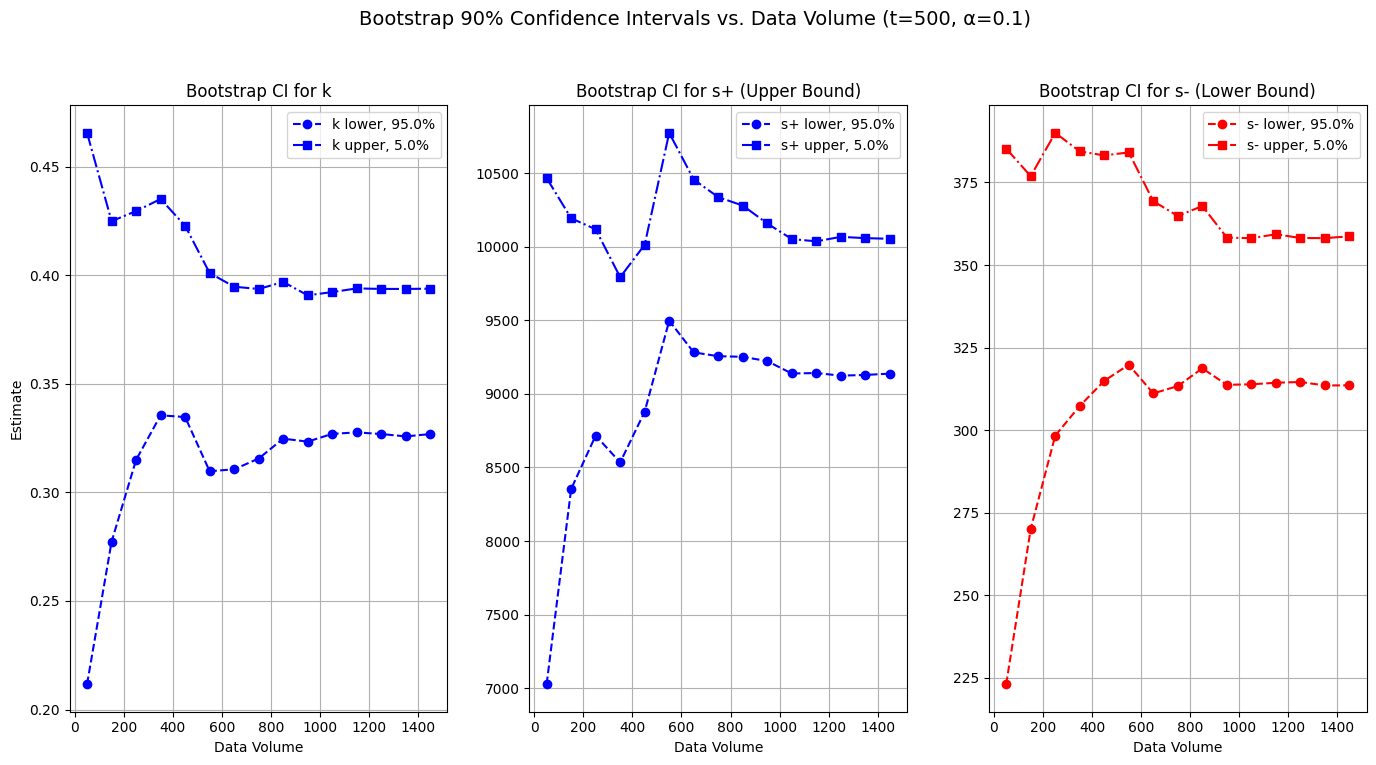

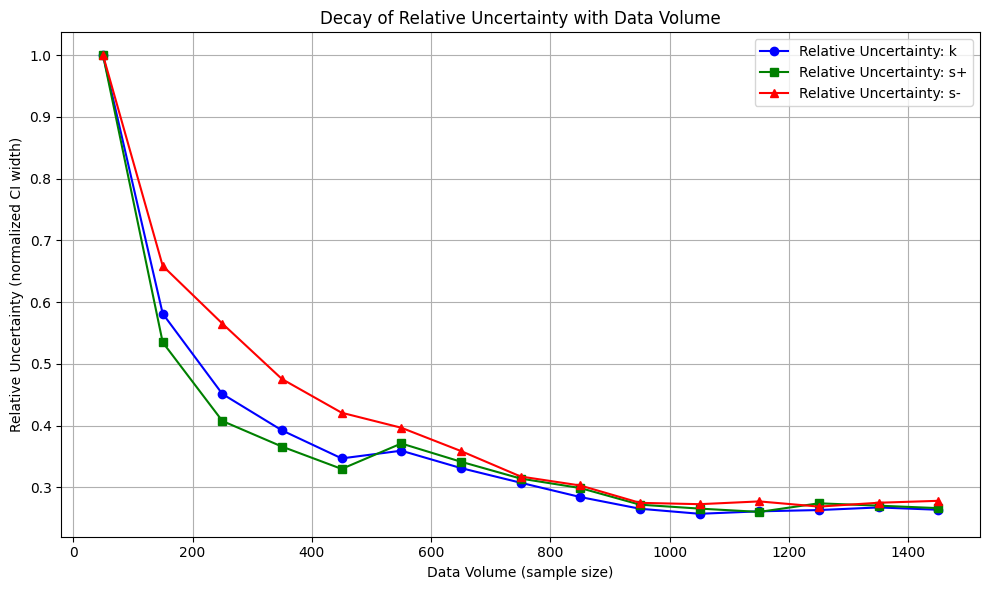

In [2]:
sampling_uncertainty_experiment(B=5_000) # for

In [3]:

def sampling_uncertainty_experiment_v2(B=100):

    np.random.seed(42)
    true_data = np.random.weibull(a=1.5, size=1000) * 5000  # scaled to make times reasonable

    # Evaluate for increasing data volumes
    data_sizes = np.arange(100, 5_000, 100)
    t_eval = 500
    alpha_levels = [0.05, 0.1, 0.2]  # Multiple alpha levels

    fig, axs = plt.subplots(len(alpha_levels), 3, figsize=(14, 4 * len(alpha_levels)), sharex=True)

    for i, alpha in enumerate(alpha_levels):
        alpha_bootstrap = alpha
        print_lvl = int(100 * (1 - alpha_bootstrap))

        s_minus_bounds = []
        s_plus_bounds = []
        k_bounds = []
        for size in data_sizes:
            ttf_subset = true_data[:size]
            s_m_bounds, s_p_bounds, k_p_bounds = bootstrap_s_bounds(ttf_subset, t=t_eval, B=B,
                                                                    alpha=0.1, alpha_bstp=alpha_bootstrap)
            s_minus_bounds.append(s_m_bounds)
            s_plus_bounds.append(s_p_bounds)
            k_bounds.append(k_p_bounds)

        s_minus_bounds = np.array(s_minus_bounds)
        s_plus_bounds = np.array(s_plus_bounds)
        k_bounds = np.array(k_bounds)

        # Panel 1: k bounds
        axs[i, 0].plot(data_sizes, k_bounds[:, 0], 'b--o', label=f'k lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i, 0].plot(data_sizes, k_bounds[:, 1], 'b-.s', label=f'k upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i, 0].set_title(f"Bootstrap CI for k (α={alpha})")
        axs[i, 0].set_xlabel("Data Volume")
        axs[i, 0].set_ylabel("Estimate")
        axs[i, 0].grid(True)
        axs[i, 0].legend()
        axs[i, 0].set_ylim([0.1,0.5])
        # Panel 2: s+ bounds
        axs[i,1].plot(data_sizes, s_plus_bounds[:, 0], 'b--o', label=f's+ lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i,1].plot(data_sizes, s_plus_bounds[:, 1], 'b-.s', label=f's+ upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i,1].set_title("Bootstrap CI for s+ (Upper Bound)")
        axs[i,1].set_xlabel("Data Volume")
        axs[i,1].grid(True)
        axs[i,1].legend()
        axs[i,1].set_ylim([8_000,11_000])
        # Panel 3: s− bounds
        axs[i,2].plot(data_sizes, s_minus_bounds[:, 0], 'r--o', label=f's- lower, {int(100 * (1 - alpha_bootstrap / 2))}%')
        axs[i,2].plot(data_sizes, s_minus_bounds[:, 1], 'r-.s', label=f's- upper, {int(100 * (alpha_bootstrap / 2))}%')
        axs[i,2].set_title("Bootstrap CI for s- (Lower Bound)")
        axs[i,2].set_xlabel("Data Volume")
        axs[i,2].grid(True)
        axs[i,2].legend()
        axs[i,2].set_ylim([250,400])


    plt.suptitle(f"Bootstrap Confidence Intervals vs. Data Volume (t={t_eval})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



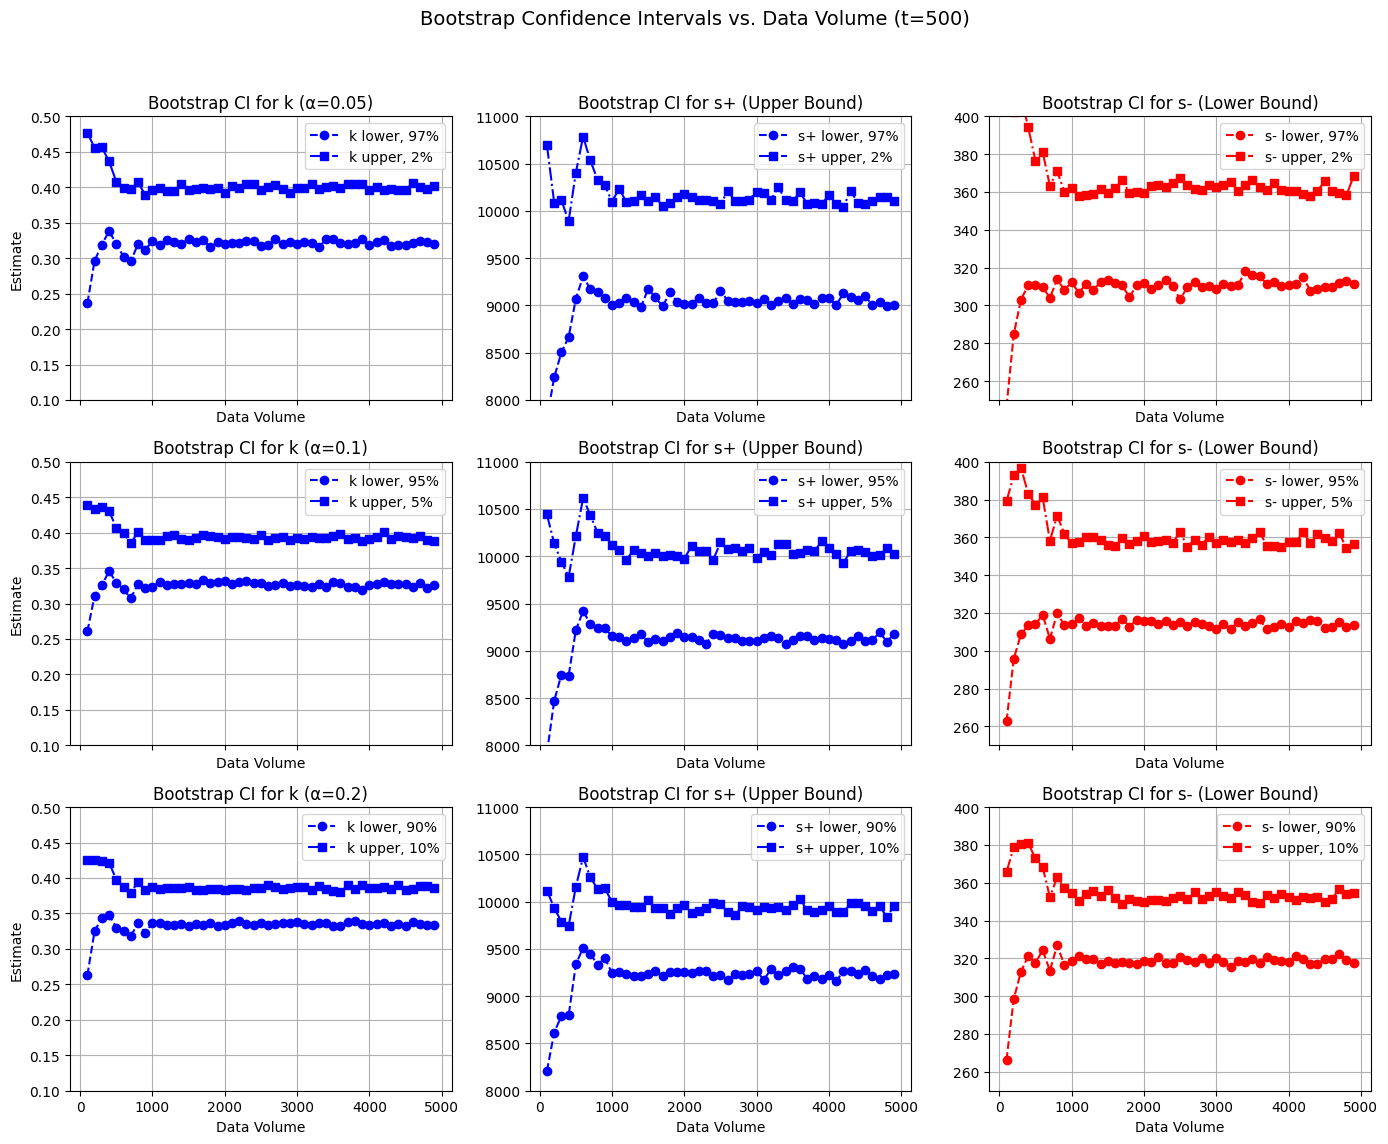

In [4]:
sampling_uncertainty_experiment_v2(B=200)

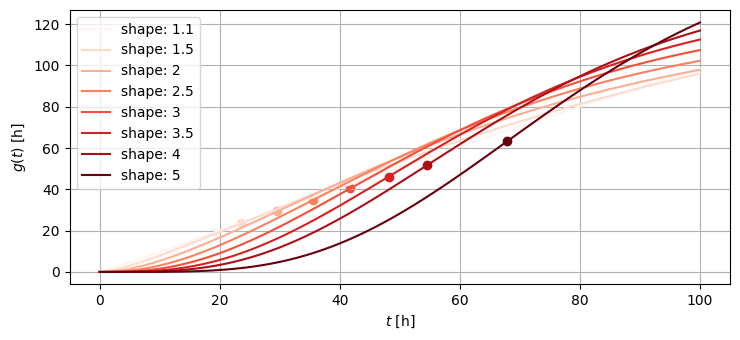

<Figure size 750x350 with 0 Axes>

In [5]:

def gammainc_low(a, z):
    return gammainc(a, 0, z, regularized=True)

def f(x, a: float =3, lambd: float = 0.0478):
    z = float(lambd) * float(x)
    w = gammainc_low(a, z)
    ww = 1 - w
    u = fadd(a, 1)
    u1 = fsub(a, 1)
    v = fdiv(u1, 2)
    y = power(ww, v)
    r = 1 - y
    gn = fmul(a, u)
    gd = float(lambd) * float(fsub(a, 1))
    g1 = fdiv(gn, gd)
    result = g1 * r
    return result

def get_inflection(time, gt):
    dg_dt = np.diff(gt)
    idx_max = np.argmax(dg_dt)
    t_start = time[idx_max]
    return t_start, gt[idx_max]

if __name__ == '__main__':

    a = 3
    lambd = 0.0478
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    T = np.linspace(0, 100, 1000)
    styles = ['-', ':', '-', ':r', '-k', ':k']
    a_vals = [1.1, 1.5, 2, 2.5, 3, 3.5, 4, 5]
    norm = plt.Normalize(min(a_vals), max(a_vals))
    colors = plt.cm.Reds(np.linspace(0, 1, len(a_vals)))
    for a,  col in zip(a_vals, colors):
        Gt = np.array([float(f(t, a=a, lambd=lambd)) for t in T])
        plt.plot(T, Gt,  label=f'shape: {a}', color= col)
        t_max, g_max = get_inflection(T, Gt)
        plt.scatter(t_max, g_max, color=col)
    plt.legend()
    plt.grid()
    plt.xlabel(r'$t$ [h]')
    plt.ylabel(r'$g(t)$ [h]')
    plt.show()
    plt.savefig('g for Gamma.png')
    plt.savefig(' g for gamma.pdf')


In [6]:
T = np.linspace(0, 100, 1000)  # Example: create a time vector

n_loops = 500
lambd_true = 0.0478
a_true = 4

Gt_save_nsam, tg_max_nsam = [],  []
COLS = ['r', 'b', 'k', 'g']
num_samples_list = [10, 50]

for Id, num_samples in enumerate(num_samples_list):
  COLOR = COLS[Id]
  Gt_save, tg_max, cpu_time = [], [], []

  for step in range(n_loops):
      # gamma random numbers....
      ttf_data = np.random.gamma(shape=a_true, scale=1/lambd_true, size=num_samples)
      # Estimate shape (a), loc, and scale (1/lambd) from ttf_data
      a_estimate, loc, scale_estimate = gamma.fit(ttf_data, floc=0)
      lambd_estimate = 1 / scale_estimate
      #tic = time.time()
      if step in [10, 100, 500]:
        print(f'step: {step}/{n_loops}')
        print(f'Estimators: Shape (a) = {a_estimate:.4f}, Lambda = {1 / scale_estimate:.4f}')
      # Get exact g(t)
      Gt = np.array([float(f(t, a=a_estimate, lambd=lambd_estimate)) for t in T])
      Gt_save.append(Gt)
      #toc = tic - time.time()
      # Get inflection point
      t_max, g_max = get_inflection(T, Gt)
      tg_max.append([t_max, g_max])
      #cpu_time.append(toc)
  Gt_save_nsam.append(Gt_save)
  tg_max_nsam.append(tg_max)



step: 10/500
Estimators: Shape (a) = 5.2325, Lambda = 0.0714
step: 100/500
Estimators: Shape (a) = 5.4405, Lambda = 0.0585
step: 10/500
Estimators: Shape (a) = 3.4621, Lambda = 0.0448
step: 100/500
Estimators: Shape (a) = 5.1143, Lambda = 0.0662


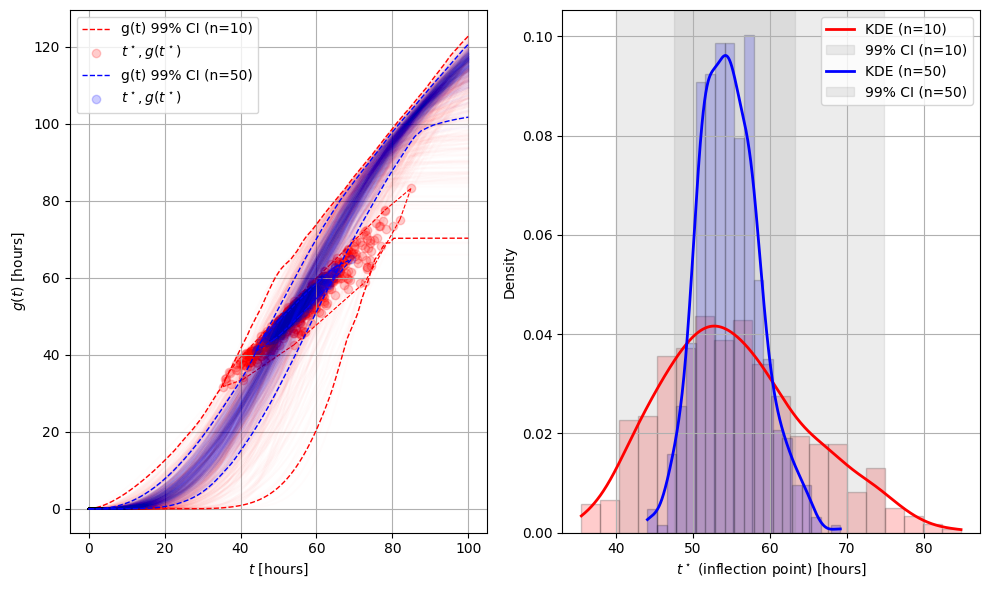

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for Gt_save, tg_max, COLOR, num_samples in  zip(Gt_save_nsam, tg_max_nsam, COLS, num_samples_list):
      # Prepare values
      Gt_array = np.array(Gt_save)  # shape (n_curves, len(T))
      Gt_lower = np.percentile(Gt_array, 0.5, axis=0)
      Gt_upper = np.percentile(Gt_array, 99.5, axis=0)

      # Plot all G(t) curves
      for Gt in Gt_array:
          axs[0].plot(T, Gt, COLOR, alpha=0.01)

      # Plot confidence bounds
      axs[0].plot(T, Gt_lower, f'{COLOR}--', linewidth=1, label=f'g(t) 99% CI (n={num_samples})')
      axs[0].plot(T, Gt_upper, f'{COLOR}--', linewidth=1)

      # Scatter points
      t_max_values = [t_max for t_max, g_max in tg_max]
      g_max_values = [g_max for t_max, g_max in tg_max]
      axs[0].scatter(t_max_values, g_max_values, c=COLOR, alpha=0.2, label=r'$t^\star, g(t^\star)$')

      # Convex hull
      points = np.column_stack((t_max_values, g_max_values))
      hull = ConvexHull(points)
      for simplex in hull.simplices:
          axs[0].plot(points[simplex, 0], points[simplex, 1], f'{COLOR}--', linewidth=0.8)

      axs[0].grid(True)
      axs[0].set_xlabel(r'$t$ [hours]')
      axs[0].set_ylabel(r'$g(t)$ [hours]')
      axs[0].legend()

      # Histogram with KDE and 95% CI
      axs[1].hist(t_max_values, bins=20, density=True, color=COLOR, alpha=0.2, edgecolor='black')
      kde = gaussian_kde(t_max_values)
      x_vals = np.linspace(min(t_max_values), max(t_max_values), 1000)
      axs[1].plot(x_vals, kde(x_vals), color=COLOR, lw=2, label=f'KDE (n={num_samples})')

      # 95% Confidence interval
      lower_ci = np.percentile(t_max_values, 2.5)
      upper_ci = np.percentile(t_max_values, 97.5)
      axs[1].axvspan(lower_ci, upper_ci, color='gray', alpha=0.15, label=f'99% CI (n={num_samples})')

      axs[1].grid(True)
      axs[1].set_xlabel(r'$t^\star$ (inflection point) [hours]')
      axs[1].set_ylabel('Density')
      axs[1].legend()


plt.tight_layout()
plt.show()